<a href="https://colab.research.google.com/github/dannynacker/strobe_depression/blob/main/vhq_exp4_int_alt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mixed-linear repeated-measures model results:

--- Model for Geometric_Content ---
                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     mean_score
No. Observations:       128         Method:                 REML      
No. Groups:             32          Scale:                  0.9798    
Min. group size:        4           Log-Likelihood:         -190.8689 
Max. group size:        4           Converged:              Yes       
Mean group size:        4.0                                           
----------------------------------------------------------------------
                             Coef. Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    3.375    0.147 23.006 0.000  3.087  3.663
session_type[T.Intervention] 1.135    0.175  6.489 0.000  0.792  1.478
Group Var                    0.199    0.131                           



--- Mode

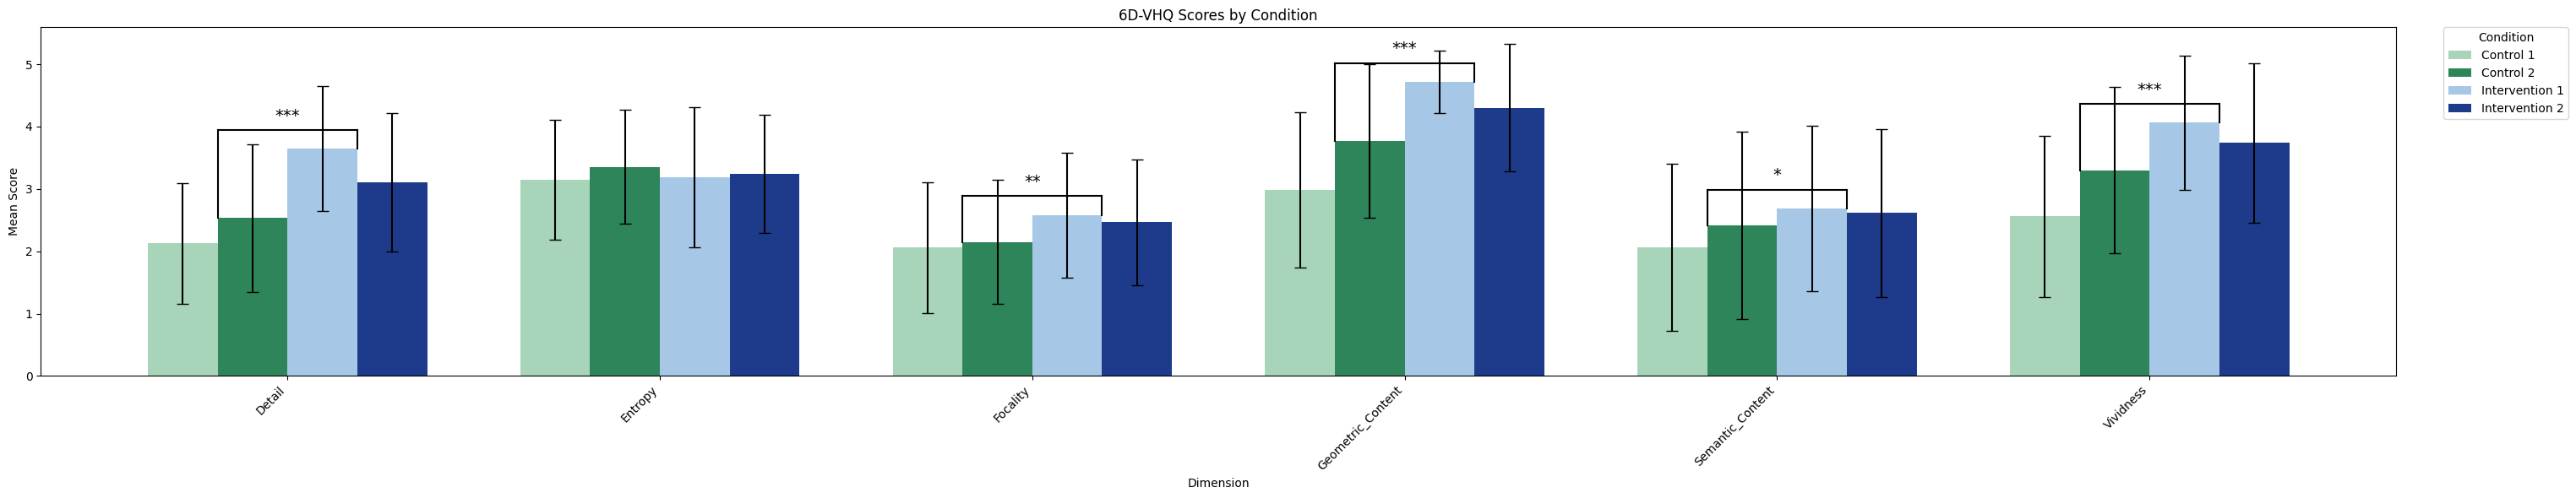

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf

# === 1. Load and clean CSV ===
csv_path = "/content/n32apr20.csv"
df = pd.read_csv(csv_path)

# Define dimensions and their associated items
vhq_dimensions = {
    "Geometric_Content": ['vhq_1', 'vhq_2', 'vhq_3'],
    "Semantic_Content": ['vhq_4', 'vhq_5', 'vhq_6'],
    "Detail": ['vhq_7', 'vhq_8', 'vhq_9'],
    "Vividness": ['vhq_10', 'vhq_11', 'vhq_12'],
    "Entropy": ['vhq_13', 'vhq_14', 'vhq_15'],
    "Focality": ['vhq_16', 'vhq_17', 'vhq_18'],
}

# Items that require reverse scoring
vhq_reverse_items = ['vhq_10', 'vhq_11', 'vhq_12', 'vhq_17']

# Convert relevant columns to numeric and reverse-score as needed
vhq_cols = [q for qs in vhq_dimensions.values() for q in qs]
df[vhq_cols] = df[vhq_cols].apply(pd.to_numeric, errors='coerce')
for col in vhq_reverse_items:
    if col in df.columns:
        df[col] = 6 - df[col]  # Assuming a 1-5 scale

# === 2. Compute participant-level VHQ scores ===
vhq_results = []
for (pid, session), group in df.groupby(["part_id", "session_n"]):
    row = group.iloc[0]
    # Compute the mean for each dimension for that participant
    vhq_scores = {
        dim: row[items].mean()
        for dim, items in vhq_dimensions.items()
        if all(item in row.index for item in items)
    }
    for dim, mean_score in vhq_scores.items():
        vhq_results.append({
            "part_id": pid,
            "session_n": session,
            "dimension": dim,
            "mean_score": mean_score
        })

df_vhq = pd.DataFrame(vhq_results)

# Create a new column "session_type" based on session_n
df_vhq["session_type"] = df_vhq["session_n"].apply(lambda x: "Control" if x in [1, 2] else "Intervention")

# Optional: export individual participant scores
df_vhq.to_csv("individual_6dvhq_scores.csv", index=False)

# === 3. Calculate group-level statistics (mean and SD) per session and dimension ===
grouped_vhq_stats = df_vhq.groupby(["session_n", "dimension"])["mean_score"]\
                           .agg(mean_score="mean", sd_score="std")\
                           .reset_index()

# Optional: export aggregated scores
grouped_vhq_stats.to_csv("grouped_6dvhq_scores_with_sd.csv", index=False)

# === 4. Mixed-linear repeated-measures models ===
# We model each dimension (as outcome) predicted by session_type with a random intercept for each participant.
# The model: mean_score ~ session_type + (1|part_id)
# We'll analyze these five dimensions (feel free to adjust as needed):
dimensions_to_analyze = ["Geometric_Content", "Semantic_Content", "Detail", "Vividness", "Entropy", "Focality"]

print("Mixed-linear repeated-measures model results:\n")
models = {}
for dim in dimensions_to_analyze:
    sub_df = df_vhq[df_vhq["dimension"] == dim].copy()
    model = smf.mixedlm("mean_score ~ session_type", data=sub_df, groups=sub_df["part_id"])
    result = model.fit()
    models[dim] = result
    print(f"--- Model for {dim} ---")
    print(result.summary())
    print("\n")

# Extract the p-values for the session_type effect from the models
# (i.e. for the coefficient session_type[T.Intervention])
model_sig_results = pd.DataFrame({
    "dimension": list(models.keys()),
    "p_value": [models[dim].pvalues.get("session_type[T.Intervention]", np.nan) for dim in models]
})
print("Mixed model-based significance results:")
print(model_sig_results)

# === 5. Plot grouped bar chart with individual sessions, SD error bars, and significance annotations ---
def plot_grouped_bar_with_sd(df_stats, title, sig_results=None):
    """
    Plots a grouped bar chart (individual sessions per dimension) with error bars (SD).
    If sig_results (DataFrame with 'dimension' and 'p_value') is provided, it will annotate
    each dimension with significance stars based on the provided p-values.

    Assumes df_stats has columns: 'dimension', 'session_n', 'mean_score', and 'sd_score'
    """
    # Pivot the aggregated stats for means and SDs using session_n as columns
    pivot_mean = df_stats.pivot(index="dimension", columns="session_n", values="mean_score")
    pivot_sd   = df_stats.pivot(index="dimension", columns="session_n", values="sd_score")

    # Map session_n to condition names for clarity and to match our color scheme
    session_mapping = {
        1: "Control 1",
        2: "Control 2",
        3: "Intervention 1",
        4: "Intervention 2"
    }
    pivot_mean.rename(columns=session_mapping, inplace=True)
    pivot_sd.rename(columns=session_mapping, inplace=True)

    # Define custom colors for the conditions
    condition_colors = {
        "Control 1": "#A8D5BA",          # light green
        "Control 2": "#2F855A",          # dark green
        "Intervention 1": "#A7C7E7",     # light blue
        "Intervention 2": "#1E3A8A",     # dark blue
    }

    # Define desired order
    desired_order = ["Control 1", "Control 2", "Intervention 1", "Intervention 2"]
    pivot_mean = pivot_mean[desired_order]
    pivot_sd   = pivot_sd[desired_order]

    # Create color list in the desired order
    color_list = [condition_colors.get(cond, "#888888") for cond in desired_order]

    # Determine bar positions for each dimension (group)
    n_groups = len(pivot_mean.index)
    n_bars = len(desired_order)
    indices = np.arange(n_groups)

    total_width = 0.75  # total width for all bars in one group
    bar_width = total_width / n_bars
    offsets = np.linspace(-total_width/2 + bar_width/2, total_width/2 - bar_width/2, n_bars)

    # Create the plot
    fig, ax = plt.subplots(figsize=(36, 6))

    for i, condition in enumerate(desired_order):
        means = pivot_mean[condition].values
        errors = pivot_sd[condition].values
        ax.bar(indices + offsets[i], means, bar_width,
               color=color_list[i], yerr=errors, capsize=5, label=condition)

    # Set axis labels, title, and ticks
    ax.set_xticks(indices)
    ax.set_xticklabels(pivot_mean.index, rotation=45, ha='right')
    ax.set_xlabel("Dimension")
    ax.set_ylabel("Mean Score")
    ax.set_title(title)

    # --- Add significance annotations based on mixed model p-values ---
    if sig_results is not None:
        def significance_stars(p):
            if p < 0.001:
                return "***"
            elif p < 0.01:
                return "**"
            elif p < 0.05:
                return "*"
            else:
                return ""

        # Loop over each dimension (group) and annotate based on the MLM p-value
        for j, dim in enumerate(pivot_mean.index):
            # Look up the p-value for this dimension from the mixed model
            p_val_row = sig_results[sig_results['dimension'] == dim]
            if p_val_row.empty:
                continue
            p_val = p_val_row['p_value'].values[0]
            star = significance_stars(p_val)
            if star == "":
                continue  # Skip if not significant

            # Compute x positions: we average the positions of Control 1 & 2 and Intervention 1 & 2
            control_x = indices[j] + (offsets[0] + offsets[1]) / 2
            intervention_x = indices[j] + (offsets[2] + offsets[3]) / 2

            # Determine y positions: take the maximum of the corresponding bars
            control_y = max(pivot_mean.loc[dim, "Control 1"], pivot_mean.loc[dim, "Control 2"])
            intervention_y = max(pivot_mean.loc[dim, "Intervention 1"], pivot_mean.loc[dim, "Intervention 2"])
            y_line = max(control_y, intervention_y) + 0.3

            # Draw horizontal line connecting the two groups
            ax.plot([control_x, intervention_x], [y_line, y_line], color="black", lw=1.5)
            ax.plot([control_x, control_x], [control_y, y_line], color="black", lw=1.5)
            ax.plot([intervention_x, intervention_x], [intervention_y, y_line], color="black", lw=1.5)

            # Place the significance stars in the middle
            mid_x = (control_x + intervention_x) / 2
            ax.text(mid_x, y_line + 0.1, star, ha="center", va="bottom", color="black", fontsize=14)

    # Move legend outside the plot area
    ax.legend(title="Condition", bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

# === 6. Plot the figure with significance annotations based on the mixed model results ===
plot_grouped_bar_with_sd(grouped_vhq_stats, "6D-VHQ Scores by Condition", sig_results=model_sig_results)

=== Additional VHQ models: Direct session comparisons ===

--- Model for Geometric_Content ---
           Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  mean_score
No. Observations:  128      Method:              REML      
No. Groups:        32       Scale:               0.8632    
Min. group size:   4        Log-Likelihood:      -184.9311 
Max. group size:   4        Converged:           Yes       
Mean group size:   4.0                                     
-----------------------------------------------------------
                  Coef. Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         2.979    0.185 16.134 0.000  2.617  3.341
C(session_n)[T.2] 0.792    0.232  3.408 0.001  0.336  1.247
C(session_n)[T.3] 1.740    0.232  7.490 0.000  1.284  2.195
C(session_n)[T.4] 1.323    0.232  5.696 0.000  0.868  1.778
Group Var         0.228    0.140                           



--- Model for

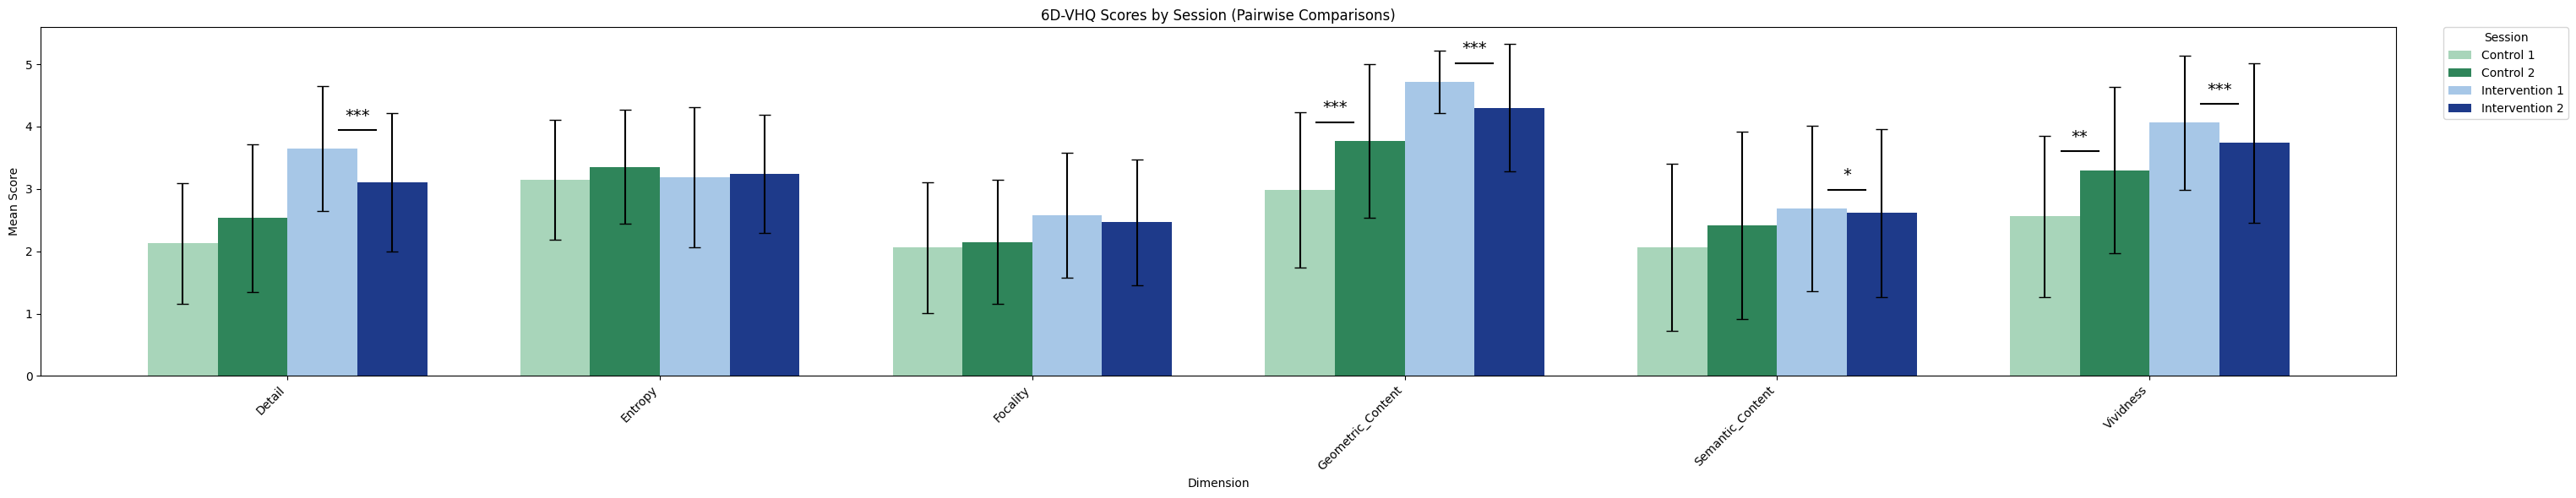

In [2]:
print("=== Additional VHQ models: Direct session comparisons ===\n")

vhq_pairwise_models = {}

for dim in dimensions_to_analyze:
    sub_df = df_vhq[df_vhq["dimension"] == dim].copy()

    # Mixed model treating session_n as categorical
    model = smf.mixedlm("mean_score ~ C(session_n)", data=sub_df, groups=sub_df["part_id"])
    result = model.fit()
    vhq_pairwise_models[dim] = result

    print(f"--- Model for {dim} ---")
    print(result.summary())
    print("\n")

# Extract p-values for 1 vs 2 and 3 vs 4
vhq_pairwise_pvals = []

for dim, result in vhq_pairwise_models.items():
    pvals = result.pvalues
    p_1v2 = pvals.get("C(session_n)[T.2]", np.nan)
    p_3v4 = pvals.get("C(session_n)[T.4]", np.nan)

    vhq_pairwise_pvals.append({
        "dimension": dim,
        "p_1_vs_2": p_1v2,
        "p_3_vs_4": p_3v4
    })

vhq_pairwise_pvals_df = pd.DataFrame(vhq_pairwise_pvals)

print("=== Pairwise VHQ comparison p-values ===")
print(vhq_pairwise_pvals_df)

# === Pivot means & SDs per session_n for plotting ===
pivot_mean_pairwise = grouped_vhq_stats.pivot(index="dimension", columns="session_n", values="mean_score")
pivot_sd_pairwise   = grouped_vhq_stats.pivot(index="dimension", columns="session_n", values="sd_score")

# Map session_n to descriptive names
session_mapping = {
    1: "Control 1",
    2: "Control 2",
    3: "Intervention 1",
    4: "Intervention 2"
}
pivot_mean_pairwise.rename(columns=session_mapping, inplace=True)
pivot_sd_pairwise.rename(columns=session_mapping, inplace=True)

# Define colors matching your scheme
condition_colors = {
    "Control 1": "#A8D5BA",
    "Control 2": "#2F855A",
    "Intervention 1": "#A7C7E7",
    "Intervention 2": "#1E3A8A"
}

desired_order = ["Control 1", "Control 2", "Intervention 1", "Intervention 2"]
color_list = [condition_colors.get(cond, "#888888") for cond in desired_order]

# === Plot ===
fig, ax = plt.subplots(figsize=(36, 6))

n_groups = len(pivot_mean_pairwise.index)
n_bars = len(desired_order)
indices = np.arange(n_groups)

total_width = 0.75
bar_width = total_width / n_bars
offsets = np.linspace(-total_width/2 + bar_width/2, total_width/2 - bar_width/2, n_bars)

for i, session in enumerate(desired_order):
    means = pivot_mean_pairwise[session].values
    errors = pivot_sd_pairwise[session].values
    ax.bar(indices + offsets[i], means, bar_width, color=color_list[i], yerr=errors, capsize=5, label=session)

ax.set_xticks(indices)
ax.set_xticklabels(pivot_mean_pairwise.index, rotation=45, ha='right')
ax.set_xlabel("Dimension")
ax.set_ylabel("Mean Score")
ax.set_title("6D-VHQ Scores by Session (Pairwise Comparisons)")

# Significance stars function
def significance_stars(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""

# Annotate pairwise comparisons: 1 vs 2 and 3 vs 4
for j, dim in enumerate(pivot_mean_pairwise.index):
    row = vhq_pairwise_pvals_df[vhq_pairwise_pvals_df['dimension'] == dim]

    # Control 1 vs Control 2
    p_1v2 = row['p_1_vs_2'].values[0]
    star_1v2 = significance_stars(p_1v2)
    if star_1v2 != "":
        x1 = indices[j] + (offsets[0] + offsets[1]) / 2
        y1 = max(pivot_mean_pairwise.loc[dim, "Control 1"], pivot_mean_pairwise.loc[dim, "Control 2"]) + 0.3
        ax.plot([x1-0.05, x1+0.05], [y1, y1], color="black", lw=1.5)
        ax.text(x1, y1 + 0.1, star_1v2, ha="center", va="bottom", fontsize=14)

    # Intervention 1 vs Intervention 2
    p_3v4 = row['p_3_vs_4'].values[0]
    star_3v4 = significance_stars(p_3v4)
    if star_3v4 != "":
        x2 = indices[j] + (offsets[2] + offsets[3]) / 2
        y2 = max(pivot_mean_pairwise.loc[dim, "Intervention 1"], pivot_mean_pairwise.loc[dim, "Intervention 2"]) + 0.3
        ax.plot([x2-0.05, x2+0.05], [y2, y2], color="black", lw=1.5)
        ax.text(x2, y2 + 0.1, star_3v4, ha="center", va="bottom", fontsize=14)

ax.legend(title="Session", bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [3]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# Assuming df_vhq is already computed as before

# === 1. Merge block information into df_vhq ===
df_vhq = df_vhq.merge(df[['part_id', 'session_n', 'block']].drop_duplicates(),
                      on=['part_id', 'session_n'],
                      how='left')

# Check that worked
print(df_vhq.head())

# === 2. Mixed Linear Models with Block x Session_Type ===
print("=== VHQ models: Effect of Block x Session_Type ===\n")

vhq_block_models = {}

for dim in dimensions_to_analyze:
    sub_df = df_vhq[df_vhq["dimension"] == dim].copy()

    # Model with interaction: treat block as categorical
    model = smf.mixedlm("mean_score ~ session_type * C(block)", data=sub_df, groups=sub_df["part_id"])
    result = model.fit()
    vhq_block_models[dim] = result

    print(f"--- Model for {dim} ---")
    print(result.summary())
    print("\n")

# === 3. Extract p-values from models ===
vhq_block_pvals = []

for dim, result in vhq_block_models.items():
    pvals = result.pvalues
    vhq_block_pvals.append({
        "dimension": dim,
        "p_session_type": pvals.get("session_type[T.Intervention]", np.nan),
        "p_block": pvals.get("C(block)[T.2]", np.nan),
        "p_interaction": pvals.get("session_type[T.Intervention]:C(block)[T.2]", np.nan)
    })

vhq_block_pvals_df = pd.DataFrame(vhq_block_pvals)

print("=== Block Effect VHQ model p-values ===")
print(vhq_block_pvals_df)

# Optional: Export to CSV
vhq_block_pvals_df.to_csv("vhq_block_effect_pvalues.csv", index=False)

   part_id  session_n          dimension  mean_score session_type  block
0    11113          1  Geometric_Content    5.000000      Control      1
1    11113          1   Semantic_Content    1.000000      Control      1
2    11113          1             Detail    2.333333      Control      1
3    11113          1          Vividness    2.666667      Control      1
4    11113          1            Entropy    4.000000      Control      1
=== VHQ models: Effect of Block x Session_Type ===

--- Model for Geometric_Content ---
                        Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          mean_score
No. Observations:            128              Method:                      REML      
No. Groups:                  32               Scale:                       0.9649    
Min. group size:             4                Log-Likelihood:              -190.1141 
Max. group size:             4                Converged:            

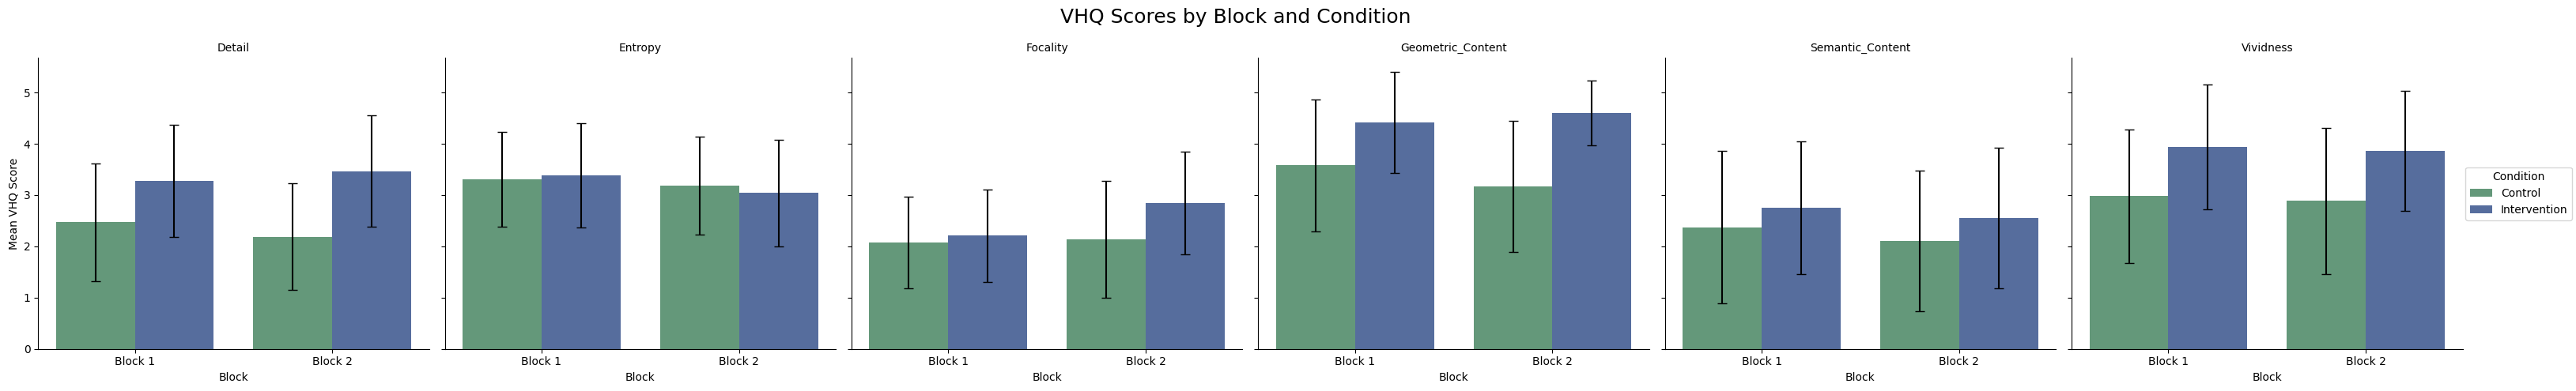

In [4]:
# === 4. Group means and SDs for Block x Session_Type plots ===
grouped_block_stats = df_vhq.groupby(["block", "session_type", "dimension"])["mean_score"] \
                            .agg(mean_score="mean", sd_score="std") \
                            .reset_index()

# Optional: save for later reuse
grouped_block_stats.to_csv("grouped_6dvhq_block_stats.csv", index=False)

import seaborn as sns

g = sns.catplot(
    data=grouped_block_stats,
    x="block",
    y="mean_score",
    hue="session_type",
    col="dimension",
    kind="bar",
    errorbar=None,
    palette={"Control": "#5BA178", "Intervention": "#4A69A9"},
    height=5,
    aspect=1,  # Adjust width per plot
    col_wrap=len(grouped_block_stats["dimension"].unique()),  # Force 1 row
)

# Add error bars
for ax, (dim, df_sub) in zip(g.axes.flatten(), grouped_block_stats.groupby("dimension")):
    for idx, row in df_sub.iterrows():
        block_offset = -0.2 if row["session_type"] == "Control" else 0.2
        ax.errorbar(
            x=row["block"] - 1 + block_offset,
            y=row["mean_score"],
            yerr=row["sd_score"],
            fmt='none',
            ecolor='black',
            capsize=4
        )
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Block 1", "Block 2"])

# Clean titles
g.set_titles("{col_name}")

# Label axes
g.set_axis_labels("Block", "Mean VHQ Score")

# Add a single overarching figure title
plt.subplots_adjust(top=0.85)
g.fig.suptitle("VHQ Scores by Block and Condition", fontsize=18)

# Update legend title
new_legend = g._legend
new_legend.set_title("Condition")

plt.tight_layout()
# Move legend outside the plot area
g._legend.set_bbox_to_anchor((1.04, 0.5))  # Move right and center vertically
g._legend.set_frame_on(True)  # Optional: Remove legend box
g._legend.set_title("Condition")  # Ensure correct title
plt.show()

Mixed-linear repeated-measures model results (exp4 vars):

--- Model for Engagement ---
                 Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      mean_score
No. Observations:       128          Method:                  REML      
No. Groups:             32           Scale:                   549.1086  
Min. group size:        4            Log-Likelihood:          -595.3266 
Max. group size:        4            Converged:               Yes       
Mean group size:        4.0                                             
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     54.937    3.943 13.931 0.000 47.208 62.667
session_type[T.Intervention]  20.484    4.142  4.945 0.000 12.365 28.603
Group Var                    223.077    4.498         

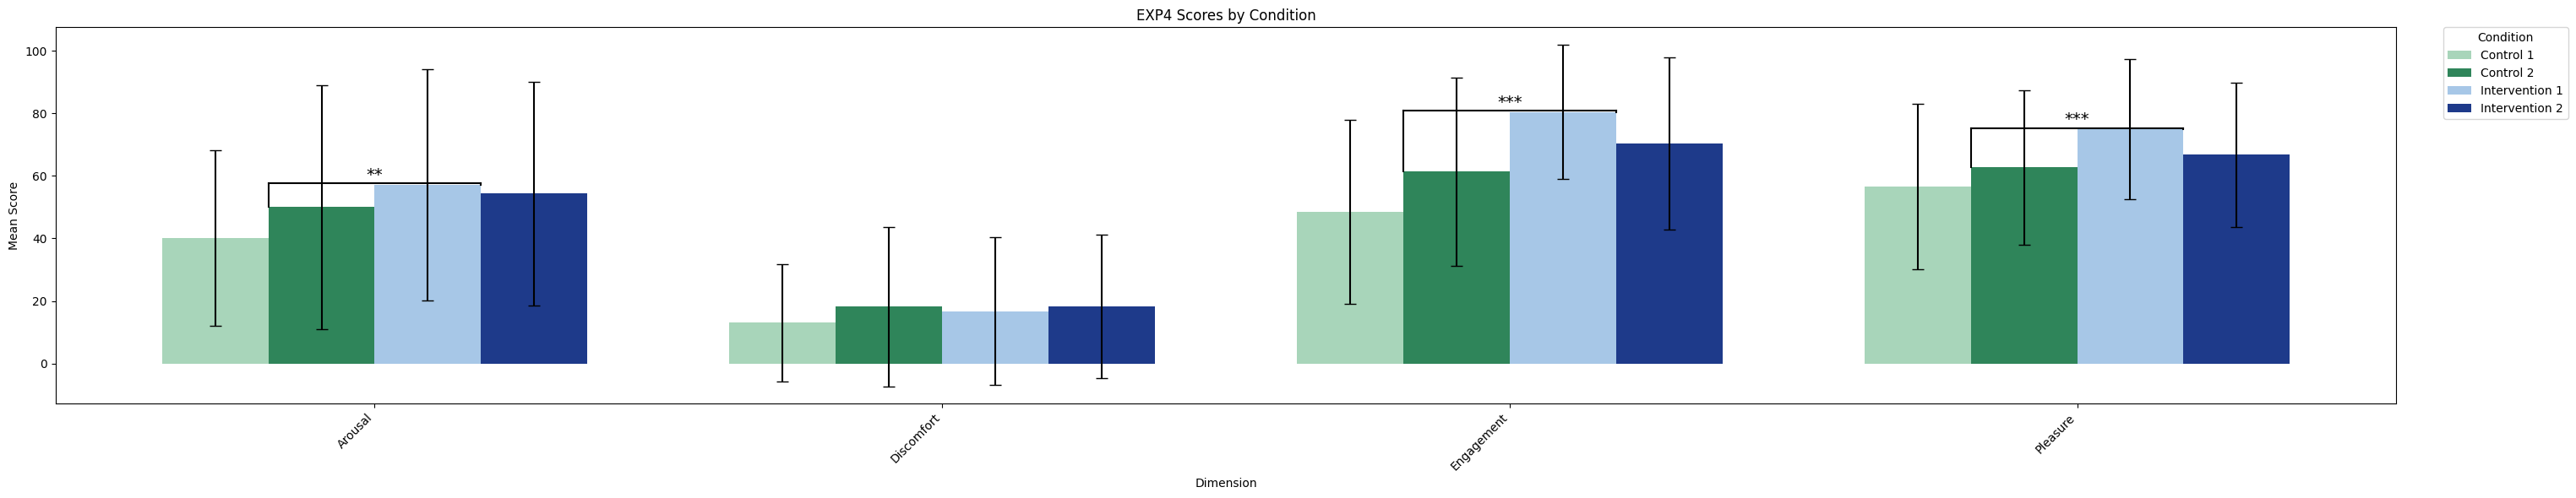

In [5]:
# === 1. Prep and Compute Participant-Level exp4 Scores ===
exp4_vars = ['exp4_engagement_1', 'exp4_pleasure_1', 'exp4_discomfort_1', 'exp4_arousal_1']

df[exp4_vars] = df[exp4_vars].apply(pd.to_numeric, errors='coerce')

exp4_results = []
for (pid, session), group in df.groupby(["part_id", "session_n"]):
    row = group.iloc[0]
    for var in exp4_vars:
        exp4_results.append({
            "part_id": pid,
            "session_n": session,
            "variable": var.replace('exp4_', '').replace('_1', '').capitalize(),  # Clean names
            "mean_score": row[var]
        })

df_exp4 = pd.DataFrame(exp4_results)
df_exp4["session_type"] = df_exp4["session_n"].apply(lambda x: "Control" if x in [1, 2] else "Intervention")

# === 2. Group-Level Stats ===
grouped_exp4_stats = df_exp4.groupby(["session_n", "variable"])["mean_score"]\
                             .agg(mean_score="mean", sd_score="std")\
                             .reset_index()

# === 3. Mixed-Linear Models for exp4 variables ===
print("Mixed-linear repeated-measures model results (exp4 vars):\n")
exp4_models = {}
for var in df_exp4["variable"].unique():
    sub_df = df_exp4[df_exp4["variable"] == var].copy()
    model = smf.mixedlm("mean_score ~ session_type", data=sub_df, groups=sub_df["part_id"])
    result = model.fit()
    exp4_models[var] = result
    print(f"--- Model for {var} ---")
    print(result.summary())
    print("\n")

exp4_sig_results = pd.DataFrame({
    "variable": list(exp4_models.keys()),
    "p_value": [exp4_models[var].pvalues.get("session_type[T.Intervention]", np.nan) for var in exp4_models]
})

print("Significance results for exp4 vars:")
print(exp4_sig_results)

# === Before plotting exp4 variables ===

# Pivot mean and SD tables for exp4 vars
pivot_mean = grouped_exp4_stats.pivot(index="variable", columns="session_n", values="mean_score")
pivot_sd   = grouped_exp4_stats.pivot(index="variable", columns="session_n", values="sd_score")

# Rename session numbers to labels
session_mapping = {
    1: "Control 1",
    2: "Control 2",
    3: "Intervention 1",
    4: "Intervention 2"
}
pivot_mean.rename(columns=session_mapping, inplace=True)
pivot_sd.rename(columns=session_mapping, inplace=True)

# Define custom colors for the conditions
condition_colors = {
    "Control 1": "#A8D5BA",          # light green
    "Control 2": "#2F855A",          # dark green
    "Intervention 1": "#A7C7E7",     # light blue
    "Intervention 2": "#1E3A8A",     # dark blue
}

# Desired condition order
desired_order = ["Control 1", "Control 2", "Intervention 1", "Intervention 2"]
pivot_mean = pivot_mean[desired_order]
pivot_sd   = pivot_sd[desired_order]

# Color list in the desired order
color_list = [condition_colors.get(cond, "#888888") for cond in desired_order]

# Now plot using your function
plot_grouped_bar_with_sd(
    grouped_exp4_stats.rename(columns={"variable": "dimension"}),
    "EXP4 Scores by Condition",
    sig_results=exp4_sig_results.rename(columns={"variable": "dimension"})
)

=== EXP4 models: Effect of Block x Session_Type ===

--- Model for Engagement ---
                         Mixed Linear Model Regression Results
Model:                        MixedLM           Dependent Variable:           score    
No. Observations:             128               Method:                       REML     
No. Groups:                   32                Scale:                        555.6613 
Min. group size:              4                 Log-Likelihood:               -589.5046
Max. group size:              4                 Converged:                    Yes      
Mean group size:              4.0                                                      
---------------------------------------------------------------------------------------
                                            Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------------------------
Intercept                                   57.344    4.928 11.

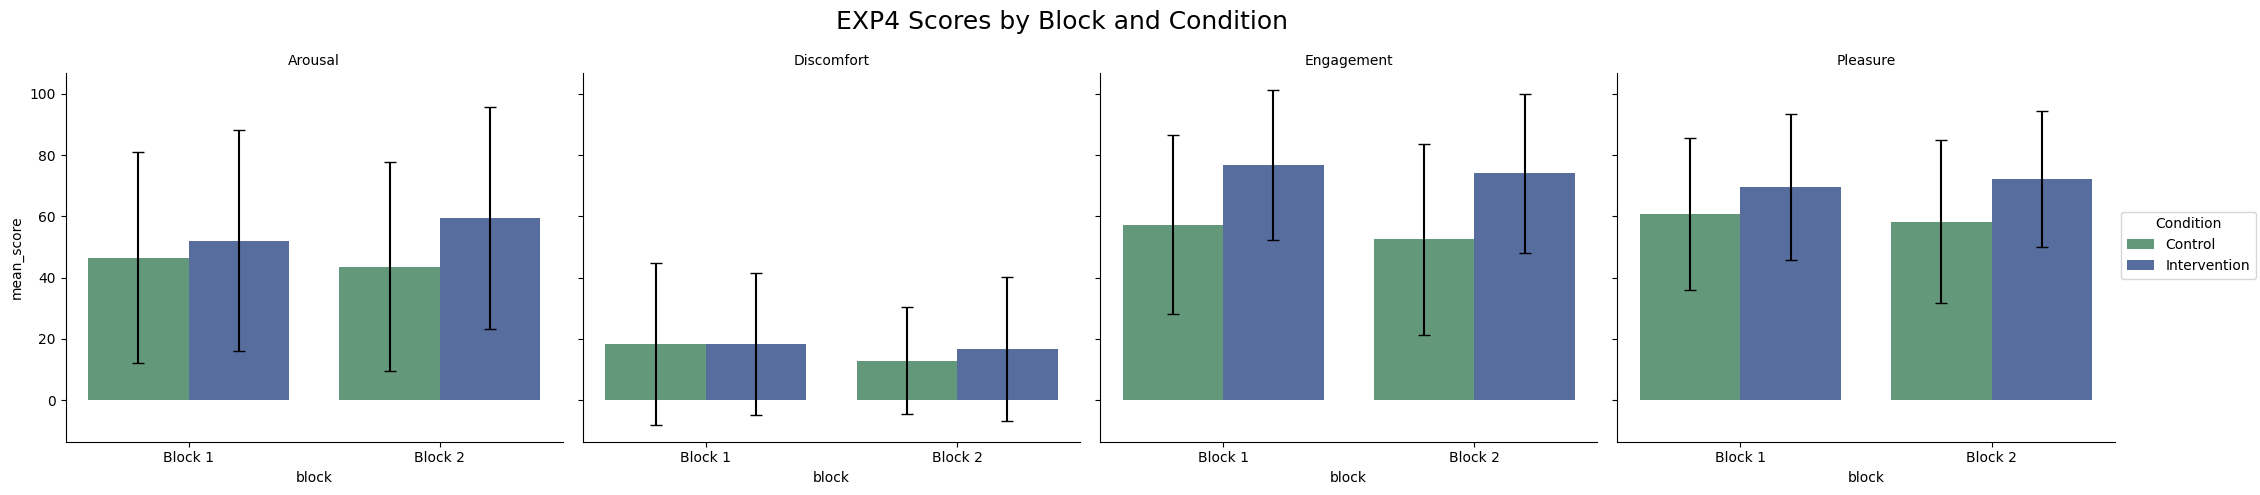

In [6]:
exp4_vars = ["exp4_engagement_1", "exp4_pleasure_1", "exp4_discomfort_1", "exp4_arousal_1"]

df_exp4 = df[["part_id", "session_n", "block"] + exp4_vars].copy()

# Add session_type (Control vs Intervention)
df_exp4["session_type"] = df_exp4["session_n"].apply(
    lambda x: "Control" if x in [1, 2] else "Intervention"
)

# Long format for modeling & plotting
df_exp4_long = df_exp4.melt(
    id_vars=["part_id", "session_n", "session_type", "block"],
    value_vars=exp4_vars,
    var_name="exp4_variable",
    value_name="score"
)

# Clean variable names
df_exp4_long["exp4_variable"] = df_exp4_long["exp4_variable"].str.replace("exp4_", "").str.replace("_1", "").str.capitalize()

print("=== EXP4 models: Effect of Block x Session_Type ===\n")

exp4_block_models = {}

for var in df_exp4_long["exp4_variable"].unique():
    sub_df = df_exp4_long[df_exp4_long["exp4_variable"] == var].copy()

    model = smf.mixedlm("score ~ session_type * C(block)", data=sub_df, groups=sub_df["part_id"])
    result = model.fit()
    exp4_block_models[var] = result

    print(f"--- Model for {var} ---")
    print(result.summary())
    print("\n")

# Extract p-values
exp4_block_pvals = []

for var, result in exp4_block_models.items():
    pvals = result.pvalues
    exp4_block_pvals.append({
        "exp4_variable": var,
        "p_session_type": pvals.get("session_type[T.Intervention]", np.nan),
        "p_block": pvals.get("C(block)[T.2]", np.nan),
        "p_interaction": pvals.get("session_type[T.Intervention]:C(block)[T.2]", np.nan)
    })

exp4_block_pvals_df = pd.DataFrame(exp4_block_pvals)

print("=== Block Effect EXP4 model p-values ===")
print(exp4_block_pvals_df)

# Calculate means & SDs
grouped_exp4_stats = df_exp4_long.groupby(["exp4_variable", "session_type", "block"])["score"].agg(
    mean_score="mean",
    sd_score="std"
).reset_index()

# Plot
g = sns.catplot(
    data=grouped_exp4_stats,
    x="block",
    y="mean_score",
    hue="session_type",
    col="exp4_variable",
    kind="bar",
    errorbar=None,
    palette={"Control": "#5BA178", "Intervention": "#4A69A9"},
    height=5,
    aspect=1,
    col_wrap=len(grouped_exp4_stats["exp4_variable"].unique())
)

for ax, (var, df_sub) in zip(g.axes.flatten(), grouped_exp4_stats.groupby("exp4_variable")):
    for idx, row in df_sub.iterrows():
        offset = -0.2 if row["session_type"] == "Control" else 0.2
        ax.errorbar(
            x=row["block"] - 1 + offset,
            y=row["mean_score"],
            yerr=row["sd_score"],
            fmt='none',
            ecolor='black',
            capsize=4
        )
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Block 1", "Block 2"])

plt.subplots_adjust(top=0.85)
g.fig.suptitle("EXP4 Scores by Block and Condition", fontsize=18)

g._legend.set_bbox_to_anchor((1.02, 0.5))
g._legend.set_frame_on(False)
g.set_titles("{col_name}")
g._legend.set_title("Condition")

plt.tight_layout()
# Move legend outside the plot area
g._legend.set_bbox_to_anchor((1.06, 0.5))  # Move right and center vertically
g._legend.set_frame_on(True)  # Optional: Remove legend box
plt.show()

The intervention sessions were ranked as eliciting more visual experiences than the control sessions (p < 0.05), as assessed via a binomial test comparing the number of times intervention vs control sessions were selected as more visually intense.

A Friedman test was used to determine whether there were significant differences in ranked visual experience across the four individual sessions. This omnibus test allowed us to assess whether any session stood out as eliciting more visual experiences, without assuming normality.

To assess inter-participant agreement and estimate effect size for the ranked session data, Kendall’s W was computed. Kendall’s W ranges from 0 (no agreement) to 1 (complete agreement), providing a nonparametric effect size estimate of the consistency of participants’ session rankings.

For visualization, individual session rankings and group-level rankings (Control vs Intervention) were plotted with standard error bars and significance annotations reflecting statistical tests. Group-level comparisons are displayed using nested brackets to clarify that the comparison was made between grouped session types (e.g., Control 1 & 2 vs Intervention 1 & 2), rather than across all individual sessions.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 16.9 MB/s eta 0:00:00

Counts of Higher Ranked Sessions
|    |   count |   count |
|----|---------|---------|
|  0 |       1 |      11 |
|  1 |       2 |       3 |
|  2 |       3 |      15 |
|  3 |       4 |      24 |

Control Ranked Higher: 14
Intervention Ranked Higher: 39
Binomial test p-value: 0.000


<ipython-input-7-8fe819d0d8ab>:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Control 1', 'Control 2', 'Intervention 1', 'Intervention 2'],


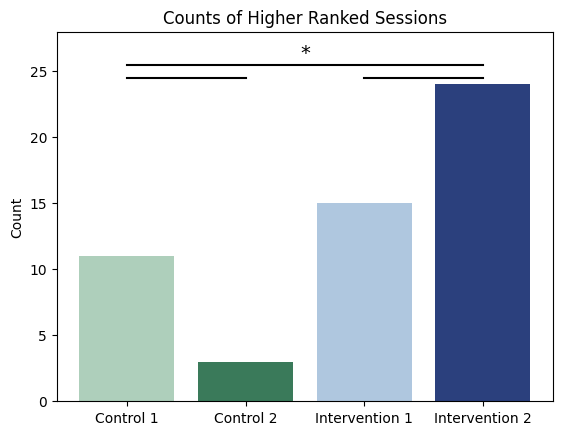

<ipython-input-7-8fe819d0d8ab>:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Control', 'Intervention'], y=[control, intervention], palette=condition_colors)


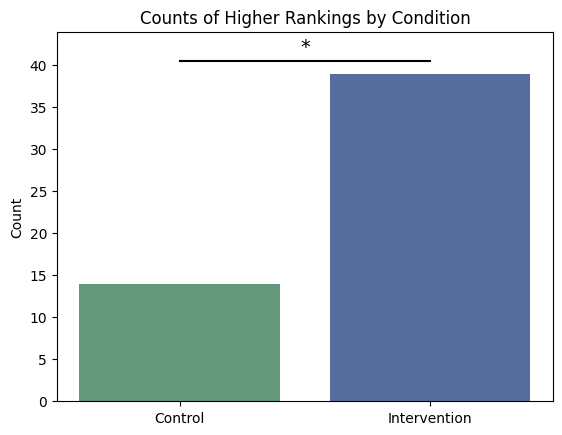

<ipython-input-7-8fe819d0d8ab>:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=summary['mean'], palette=[session_color_map[i] for i in summary.index])



Friedman Test Result
                  Q         p-unc         W
Friedman  32.368421  4.376550e-07  0.567867


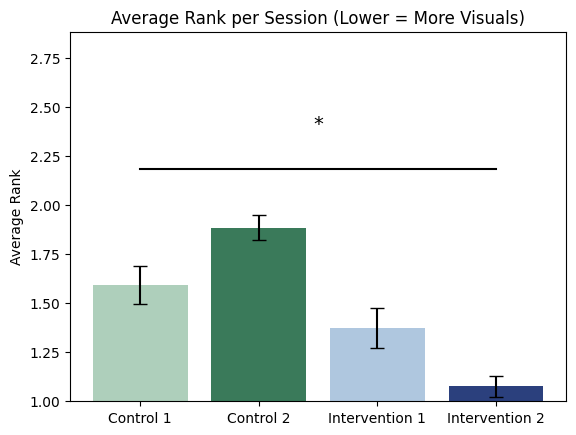

In [7]:
# Install required packages
!pip install pandas matplotlib seaborn scipy pingouin tabulate

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from scipy.stats import binomtest
import pingouin as pg

# Load CSV
df = pd.read_csv('/content/n32apr20.csv')

# Colors
session_color_map = {1: "#A8D5BA", 2: "#2F855A", 3: "#A7C7E7", 4: "#1E3A8A"}
condition_colors = {"Control": "#5BA178", "Intervention": "#4A69A9"}

# Prep ranking data
stage_session = df.groupby(['part_id', 'block', 'stage'])['session_n'].first().reset_index()
stage_pivot = stage_session.pivot(index=['part_id', 'block'], columns='stage', values='session_n').reset_index()
stage_pivot.columns = ['part_id', 'block', 'session_1', 'session_2']
rank_info = df.dropna(subset=['exp_dim_session_1'])[['part_id', 'block', 'exp_dim_session_1']].drop_duplicates()
stage_pivot = stage_pivot.merge(rank_info, on=['part_id', 'block'])

stage_pivot['higher_session_n'] = stage_pivot.apply(
    lambda x: x['session_1'] if x['exp_dim_session_1'] == 1 else x['session_2'], axis=1)

# Count frequency
session_counts = stage_pivot['higher_session_n'].value_counts().sort_index()
print("\nCounts of Higher Ranked Sessions")
print(tabulate(session_counts.reset_index().rename(columns={'index': 'session_n', 'higher_session_n': 'count'}), headers='keys', tablefmt='github'))

# Binomial: Intervention vs Control
control = session_counts.loc[[1, 2]].sum()
intervention = session_counts.loc[[3, 4]].sum()
binom_p = binomtest(intervention, intervention + control, p=0.5, alternative='greater').pvalue

print(f"\nControl Ranked Higher: {control}")
print(f"Intervention Ranked Higher: {intervention}")
print(f"Binomial test p-value: {binom_p:.3f}")

# ---- Plot 1: Count of Higher Ranked Sessions ----
# Base bar plot
plt.figure()
sns.barplot(x=['Control 1', 'Control 2', 'Intervention 1', 'Intervention 2'],
            y=session_counts.values,
            palette=[session_color_map[s] for s in session_counts.index])
plt.title('Counts of Higher Ranked Sessions')
plt.ylabel('Count')
y = session_counts.max()

# Small brackets for each group
plt.plot([0, 1], [y + 0.5, y + 0.5], color='black')  # Control
plt.plot([2, 3], [y + 0.5, y + 0.5], color='black')  # Intervention

# Big bracket across both groups
plt.plot([0, 3], [y + 1.5, y + 1.5], color='black')
plt.text(1.5, y + 2.0, '*' if binom_p < 0.05 else f'p = {binom_p:.3f}', ha='center', fontsize=14)

plt.ylim(0, y + 4)
plt.show()

# ---- Plot 2: Count of Rankings by Condition ----
plt.figure()
sns.barplot(x=['Control', 'Intervention'], y=[control, intervention], palette=condition_colors)
plt.title('Counts of Higher Rankings by Condition')
plt.ylabel('Count')
y_max = max(control, intervention)
plt.ylim(0, y_max + 5)

# Significance line
plt.plot([0, 1], [y_max + 1.5, y_max + 1.5], color='black')
plt.text(0.5, y_max + 2.5, '*' if binom_p < 0.05 else f'p = {binom_p:.3f}', ha='center', fontsize=14)
plt.show()

# ---- Rankings per participant ----
long_rankings = []
for _, row in stage_pivot.iterrows():
    if row['exp_dim_session_1'] == 1:
        long_rankings.append({'subject': row['part_id'], 'condition': row['session_1'], 'value': 1})
        long_rankings.append({'subject': row['part_id'], 'condition': row['session_2'], 'value': 2})
    else:
        long_rankings.append({'subject': row['part_id'], 'condition': row['session_1'], 'value': 2})
        long_rankings.append({'subject': row['part_id'], 'condition': row['session_2'], 'value': 1})

ranking_long_df = pd.DataFrame(long_rankings)
ranking_agg = ranking_long_df.groupby(['subject', 'condition'])['value'].mean().reset_index()

# ---- Friedman test + Kendall's W ----
friedman_result = pg.friedman(data=ranking_agg, dv='value', within='condition', subject='subject')
p_friedman = friedman_result['p-unc'].iloc[0]

print("\nFriedman Test Result")
print(friedman_result[['Q', 'p-unc', 'W']])

# ---- Plot 3: Average Rank per Session ----
summary = ranking_agg.groupby('condition')['value'].agg(['mean', 'sem']).reindex([1, 2, 3, 4])
labels = ['Control 1', 'Control 2', 'Intervention 1', 'Intervention 2']

plt.figure()
sns.barplot(x=labels, y=summary['mean'], palette=[session_color_map[i] for i in summary.index])
plt.errorbar(x=np.arange(4), y=summary['mean'], yerr=summary['sem'], fmt='none', c='black', capsize=5)

plt.title('Average Rank per Session (Lower = More Visuals)')
plt.ylabel('Average Rank')
y_max = summary['mean'].max()
plt.ylim(1, y_max + 1)

# Bracket for overall Friedman test
plt.plot([0, 3], [y_max + 0.3, y_max + 0.3], color='black')
plt.text(1.5, y_max + 0.5, '*' if p_friedman < 0.05 else f'p = {p_friedman:.3f}', ha='center', fontsize=14)

plt.xticks(rotation=0)
plt.show()

Intervention sessions were ranked as eliciting more visual experiences than control sessions (p =xxx), as assessed via a binomial test comparing the frequency of higher rankings for control (n = xxx) versus intervention sessions (n = xxx).

A Friedman test revealed a significant difference in visual experience rankings across the four individual sessions, χ²(3) = xxx, p < xxx, with a xxx degree of inter-participant agreement (Kendall’s W = xxx).

minimum meaningful difference

In [8]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel

# ==============================
# 1. Compute Effect Size (β) for VHQ Scores
# ==============================
print("=== VHQ Scores: Calculating Effect Sizes (β) by Dimension ===")

# Aggregate the VHQ participant-level data by session type and dimension.
# (Assumes that df_vhq is already computed with columns "session_type", "dimension", and "mean_score")
vhq_group = df_vhq.groupby(["session_type", "dimension"])["mean_score"].agg(['mean', 'std', 'count']).reset_index()

vhq_effects = []

# Loop over each VHQ dimension defined in your experiment.
for dim in vhq_dimensions.keys():
    # Get aggregated stats for the current dimension for both conditions.
    data_control = vhq_group[(vhq_group["session_type"] == "Control") & (vhq_group["dimension"] == dim)]
    data_intervention = vhq_group[(vhq_group["session_type"] == "Intervention") & (vhq_group["dimension"] == dim)]
    if data_control.empty or data_intervention.empty:
        continue

    # Means, SDs, and sample sizes.
    mean_control = data_control["mean"].values[0]
    std_control = data_control["std"].values[0]
    n_control = data_control["count"].values[0]

    mean_intervention = data_intervention["mean"].values[0]
    std_intervention = data_intervention["std"].values[0]
    n_intervention = data_intervention["count"].values[0]

    # Pooled standard deviation calculation.
    pooled_sd = np.sqrt(((n_control - 1) * std_control**2 + (n_intervention - 1) * std_intervention**2) / (n_control + n_intervention - 2))

    # Calculate the standardized difference (β).
    beta_vhq = (mean_intervention - mean_control) / pooled_sd

    # Retrieve the p-value from your mixed-model results DataFrame (assumed to be model_sig_results).
    # It is assumed that model_sig_results has a column "dimension" and "p_value".
    p_val = model_sig_results.loc[model_sig_results["dimension"] == dim, "p_value"].values[0]

    # Interpret the effect based on your thresholds:
    #  • Meaningful if β ≥ 0.5 and p < 0.05.
    #  • Trend if β is between 0.25 and 0.5 with p < 0.10.
    if beta_vhq >= 0.5 and p_val < 0.05:
        interpretation = "Meaningful intervention effect"
    elif 0.25 <= beta_vhq < 0.5 and p_val < 0.10:
        interpretation = "Trend toward meaningful difference"
    else:
        interpretation = "Not meaningful"

    vhq_effects.append({
        "Dimension": dim,
        "Mean_Control": mean_control,
        "Mean_Intervention": mean_intervention,
        "Beta (Cohen's d)": beta_vhq,
        "p-value": p_val,
        "Interpretation": interpretation
    })

df_vhq_effects = pd.DataFrame(vhq_effects)
print(df_vhq_effects)


# ==============================
# 2. Compute Effect Size (β) for Visual Experience Ranking Scores
# ==============================
print("\n=== Visual Experience Ranking Scores: Calculating Effect Size (β) ===")

# For the ranking data:
# It is assumed that ranking_long_df exists with columns "subject", "condition", and "value".
# Here we assign a "session_type" (Control for conditions 1 & 2; Intervention for 3 & 4).
ranking_agg = ranking_long_df.copy()
ranking_agg["session_type"] = ranking_agg["condition"].apply(lambda x: "Control" if x in [1, 2] else "Intervention")

# Compute the average ranking score per subject per session type.
subj_ranking = ranking_agg.groupby(["subject", "session_type"])["value"].mean().reset_index()

# Pivot the data so each subject has a Control and an Intervention value.
subj_ranking_pivot = subj_ranking.pivot(index="subject", columns="session_type", values="value").dropna()

control_scores = subj_ranking_pivot["Control"]
intervention_scores = subj_ranking_pivot["Intervention"]

mean_control_rank = control_scores.mean()
mean_intervention_rank = intervention_scores.mean()
n_subjects = len(subj_ranking_pivot)

# For pooled SD in a paired design, a simple approach (using independent-group pooled SD) is shown here.
# (Note: for repeated measures, consider more tailored effect size estimates.)
pooled_sd_rank = np.sqrt(((n_subjects - 1) * control_scores.std()**2 + (n_subjects - 1) * intervention_scores.std()**2) / (2*n_subjects - 2))
beta_rank = (mean_intervention_rank - mean_control_rank) / pooled_sd_rank

# Conduct a paired t-test to obtain the significance level.
t_stat, p_rank = ttest_rel(intervention_scores, control_scores)

# Interpret the ranking effect based on your criteria:
#  • Meaningful if β ≥ 0.125 with p < 0.05.
#  • Trend if β is between 0.125 and 0.25 with p < 0.10.
if beta_rank >= 0.125 and p_rank < 0.05:
    rank_interpretation = "Meaningful intervention effect"
elif 0.125 <= beta_rank < 0.25 and p_rank < 0.10:
    rank_interpretation = "Trend toward meaningful difference"
else:
    rank_interpretation = "Not meaningful"

ranking_effects = {
    "Mean_Control_Ranking": mean_control_rank,
    "Mean_Intervention_Ranking": mean_intervention_rank,
    "Beta_Ranking (Cohen's d)": beta_rank,
    "p-value": p_rank,
    "Interpretation": rank_interpretation
}

print(ranking_effects)

=== VHQ Scores: Calculating Effect Sizes (β) by Dimension ===
           Dimension  Mean_Control  Mean_Intervention  Beta (Cohen's d)  \
0  Geometric_Content      3.375000           4.510417          1.047266   
1   Semantic_Content      2.239583           2.651042          0.299254   
2             Detail      2.328125           3.375000          0.961622   
3          Vividness      2.932292           3.901042          0.761819   
4            Entropy      3.250000           3.213542         -0.037039   
5           Focality      2.104167           2.526042          0.419047   

        p-value                      Interpretation  
0  8.652472e-11      Meaningful intervention effect  
1  1.217644e-02  Trend toward meaningful difference  
2  1.960034e-09      Meaningful intervention effect  
3  1.501036e-07      Meaningful intervention effect  
4  7.809673e-01                      Not meaningful  
5  7.428328e-03  Trend toward meaningful difference  

=== Visual Experience Ranking Sco